# Experimentos com PM4Py

Exploração do log Sepsis Cases baixado da própria PM4Py: importação direta via XES, formatação para event log/dataframe, estatísticas descritivas, descoberta de processo (DFG/Inductive Miner) e execução do pipeline de Predictive RCA.


**Notas de boas práticas**

- Padronizar colunas para o formato PM4Py (`case:concept:name`, `concept:name`, `time:timestamp`, `org:resource`).
- Fixar semente para qualquer amostragem (`RANDOM_STATE`).
- Evitar filtragens que induzam viés; se amostrar, registrar o critério.
- Trabalhar com uma cópia do log para não alterar os dados brutos.


In [23]:
# Se pm4py não estiver instalado, descomente a linha abaixo
# !pip install pm4py==2.7.7 pandas matplotlib graphviz

In [24]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [25]:
import pandas as pd
import numpy as np
from pathlib import Path

import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

# Descoberta de DFG
from pm4py.algo.discovery.dfg import algorithm as dfg_algorithm
from pm4py.visualization.dfg import visualizer as dfg_visualizer

# Inductive Miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# Petri net visualization
from pm4py.visualization.petri_net import visualizer as pn_visualizer


from src.config.settings import CONFIG
from src.pipeline.pipeline_builder import PipelineBuilder
from src.models.lightgbm_model import LightGBMModel

dfg_vis_factory = dfg_visualizer
pn_vis_factory = pn_visualizer

RANDOM_STATE = CONFIG.RANDOM_STATE
DEFAULT_SLA_HOURS = CONFIG.SLA_HOURS
pd.options.display.float_format = lambda v: f"{v:.4f}"

In [26]:
xes_file = "../data/raw/xes/Sepsis Cases - Event Log.xes"

log = pm4py.read_xes(xes_file)
print("✔ Log carregado")
print(log)

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

✔ Log carregado
      InfectionSuspected org:group DiagnosticBlood DisfuncOrg  \
0                   True         A            True       True   
1                    NaN         B             NaN        NaN   
2                    NaN         B             NaN        NaN   
3                    NaN         B             NaN        NaN   
4                    NaN         C             NaN        NaN   
...                  ...       ...             ...        ...   
15209                NaN         B             NaN        NaN   
15210                NaN         E             NaN        NaN   
15211              False         L           False      False   
15212                NaN         C             NaN        NaN   
15213                NaN         L             NaN        NaN   

      SIRSCritTachypnea Hypotensie SIRSCritHeartRate Infusion  \
0                  True       True              True     True   
1                   NaN        NaN               NaN      NaN   
2       

In [27]:
# Converter log PM4Py para DataFrame
df_raw = pm4py.convert_to_dataframe(log)

# Converter timestamps
df_raw = dataframe_utils.convert_timestamp_columns_in_df(df_raw)

# Dataset para o pipeline
rename_map = {
    "case:concept:name": "case_id",
    "concept:name": "activity",
    "time:timestamp": "timestamp",
}

# Verifica se há coluna resource
if "org:resource" in df_raw.columns:
    rename_map["org:resource"] = "resource"

# Renomeia colunas
df_events = df_raw.rename(columns=rename_map)

# Adiciona coluna resource caso não exista
if "resource" not in df_events.columns:
    df_events["resource"] = np.nan

# Converte timestamps
df_events["timestamp"] = pd.to_datetime(df_events["timestamp"])

# Ordena corretamente
df_events = df_events.sort_values(["case_id", "timestamp"]).reset_index(drop=True)

df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15214 entries, 0 to 15213
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   InfectionSuspected         1050 non-null   object             
 1   org:group                  15214 non-null  object             
 2   DiagnosticBlood            1050 non-null   object             
 3   DisfuncOrg                 1050 non-null   object             
 4   SIRSCritTachypnea          1050 non-null   object             
 5   Hypotensie                 1050 non-null   object             
 6   SIRSCritHeartRate          1050 non-null   object             
 7   Infusion                   1050 non-null   object             
 8   DiagnosticArtAstrup        1050 non-null   object             
 9   activity                   15214 non-null  object             
 10  Age                        1050 non-null   float64            
 11  Di

In [28]:
# Estatísticas de variantes
variants_count = pm4py.get_variants_as_tuples(log)
variants_df = (
    pd.DataFrame(
        [{"variant": " > ".join(v), "count": c} for v, c in variants_count.items()]
    )
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)
variants_df.head(10)

,variant,count
0,ER Registration > ER Triage > ER Sepsis Triage,35
1,ER Registration > ER Triage > ER Sepsis Triage...,24
2,ER Registration > ER Triage > ER Sepsis Triage...,22
3,ER Registration > ER Triage > ER Sepsis Triage...,13
4,ER Registration > ER Triage > ER Sepsis Triage...,11
5,ER Registration > ER Triage > ER Sepsis Triage...,9
6,ER Registration > ER Triage > ER Sepsis Triage...,7
7,ER Registration > ER Triage > ER Sepsis Triage...,5
8,ER Registration > ER Triage > ER Sepsis Triage...,5
9,ER Registration > ER Triage > ER Sepsis Triage...,5


In [29]:
# Descoberta por DFG
dfg = dfg_algorithm.apply(log)
activities = pm4py.get_event_attribute_values(log, "concept:name")
dfg, list(activities.keys())

({('Admission IC', 'Admission IC'): 1,
  ('Admission IC', 'Admission NC'): 4,
  ('Admission IC', 'CRP'): 32,
  ('Admission IC', 'ER Sepsis Triage'): 1,
  ('Admission IC', 'LacticAcid'): 41,
  ('Admission IC', 'Leucocytes'): 38,
  ('Admission NC', 'Admission IC'): 20,
  ('Admission NC', 'Admission NC'): 175,
  ('Admission NC', 'CRP'): 369,
  ('Admission NC', 'ER Sepsis Triage'): 5,
  ('Admission NC', 'ER Triage'): 1,
  ('Admission NC', 'IV Antibiotics'): 2,
  ('Admission NC', 'IV Liquid'): 22,
  ('Admission NC', 'LacticAcid'): 27,
  ('Admission NC', 'Leucocytes'): 408,
  ('Admission NC', 'Release A'): 117,
  ('Admission NC', 'Release B'): 17,
  ('Admission NC', 'Release C'): 4,
  ('Admission NC', 'Release D'): 1,
  ('CRP', 'Admission IC'): 17,
  ('CRP', 'Admission NC'): 187,
  ('CRP', 'CRP'): 317,
  ('CRP', 'ER Registration'): 14,
  ('CRP', 'ER Sepsis Triage'): 35,
  ('CRP', 'ER Triage'): 16,
  ('CRP', 'IV Antibiotics'): 81,
  ('CRP', 'IV Liquid'): 111,
  ('CRP', 'LacticAcid'): 629,
  (

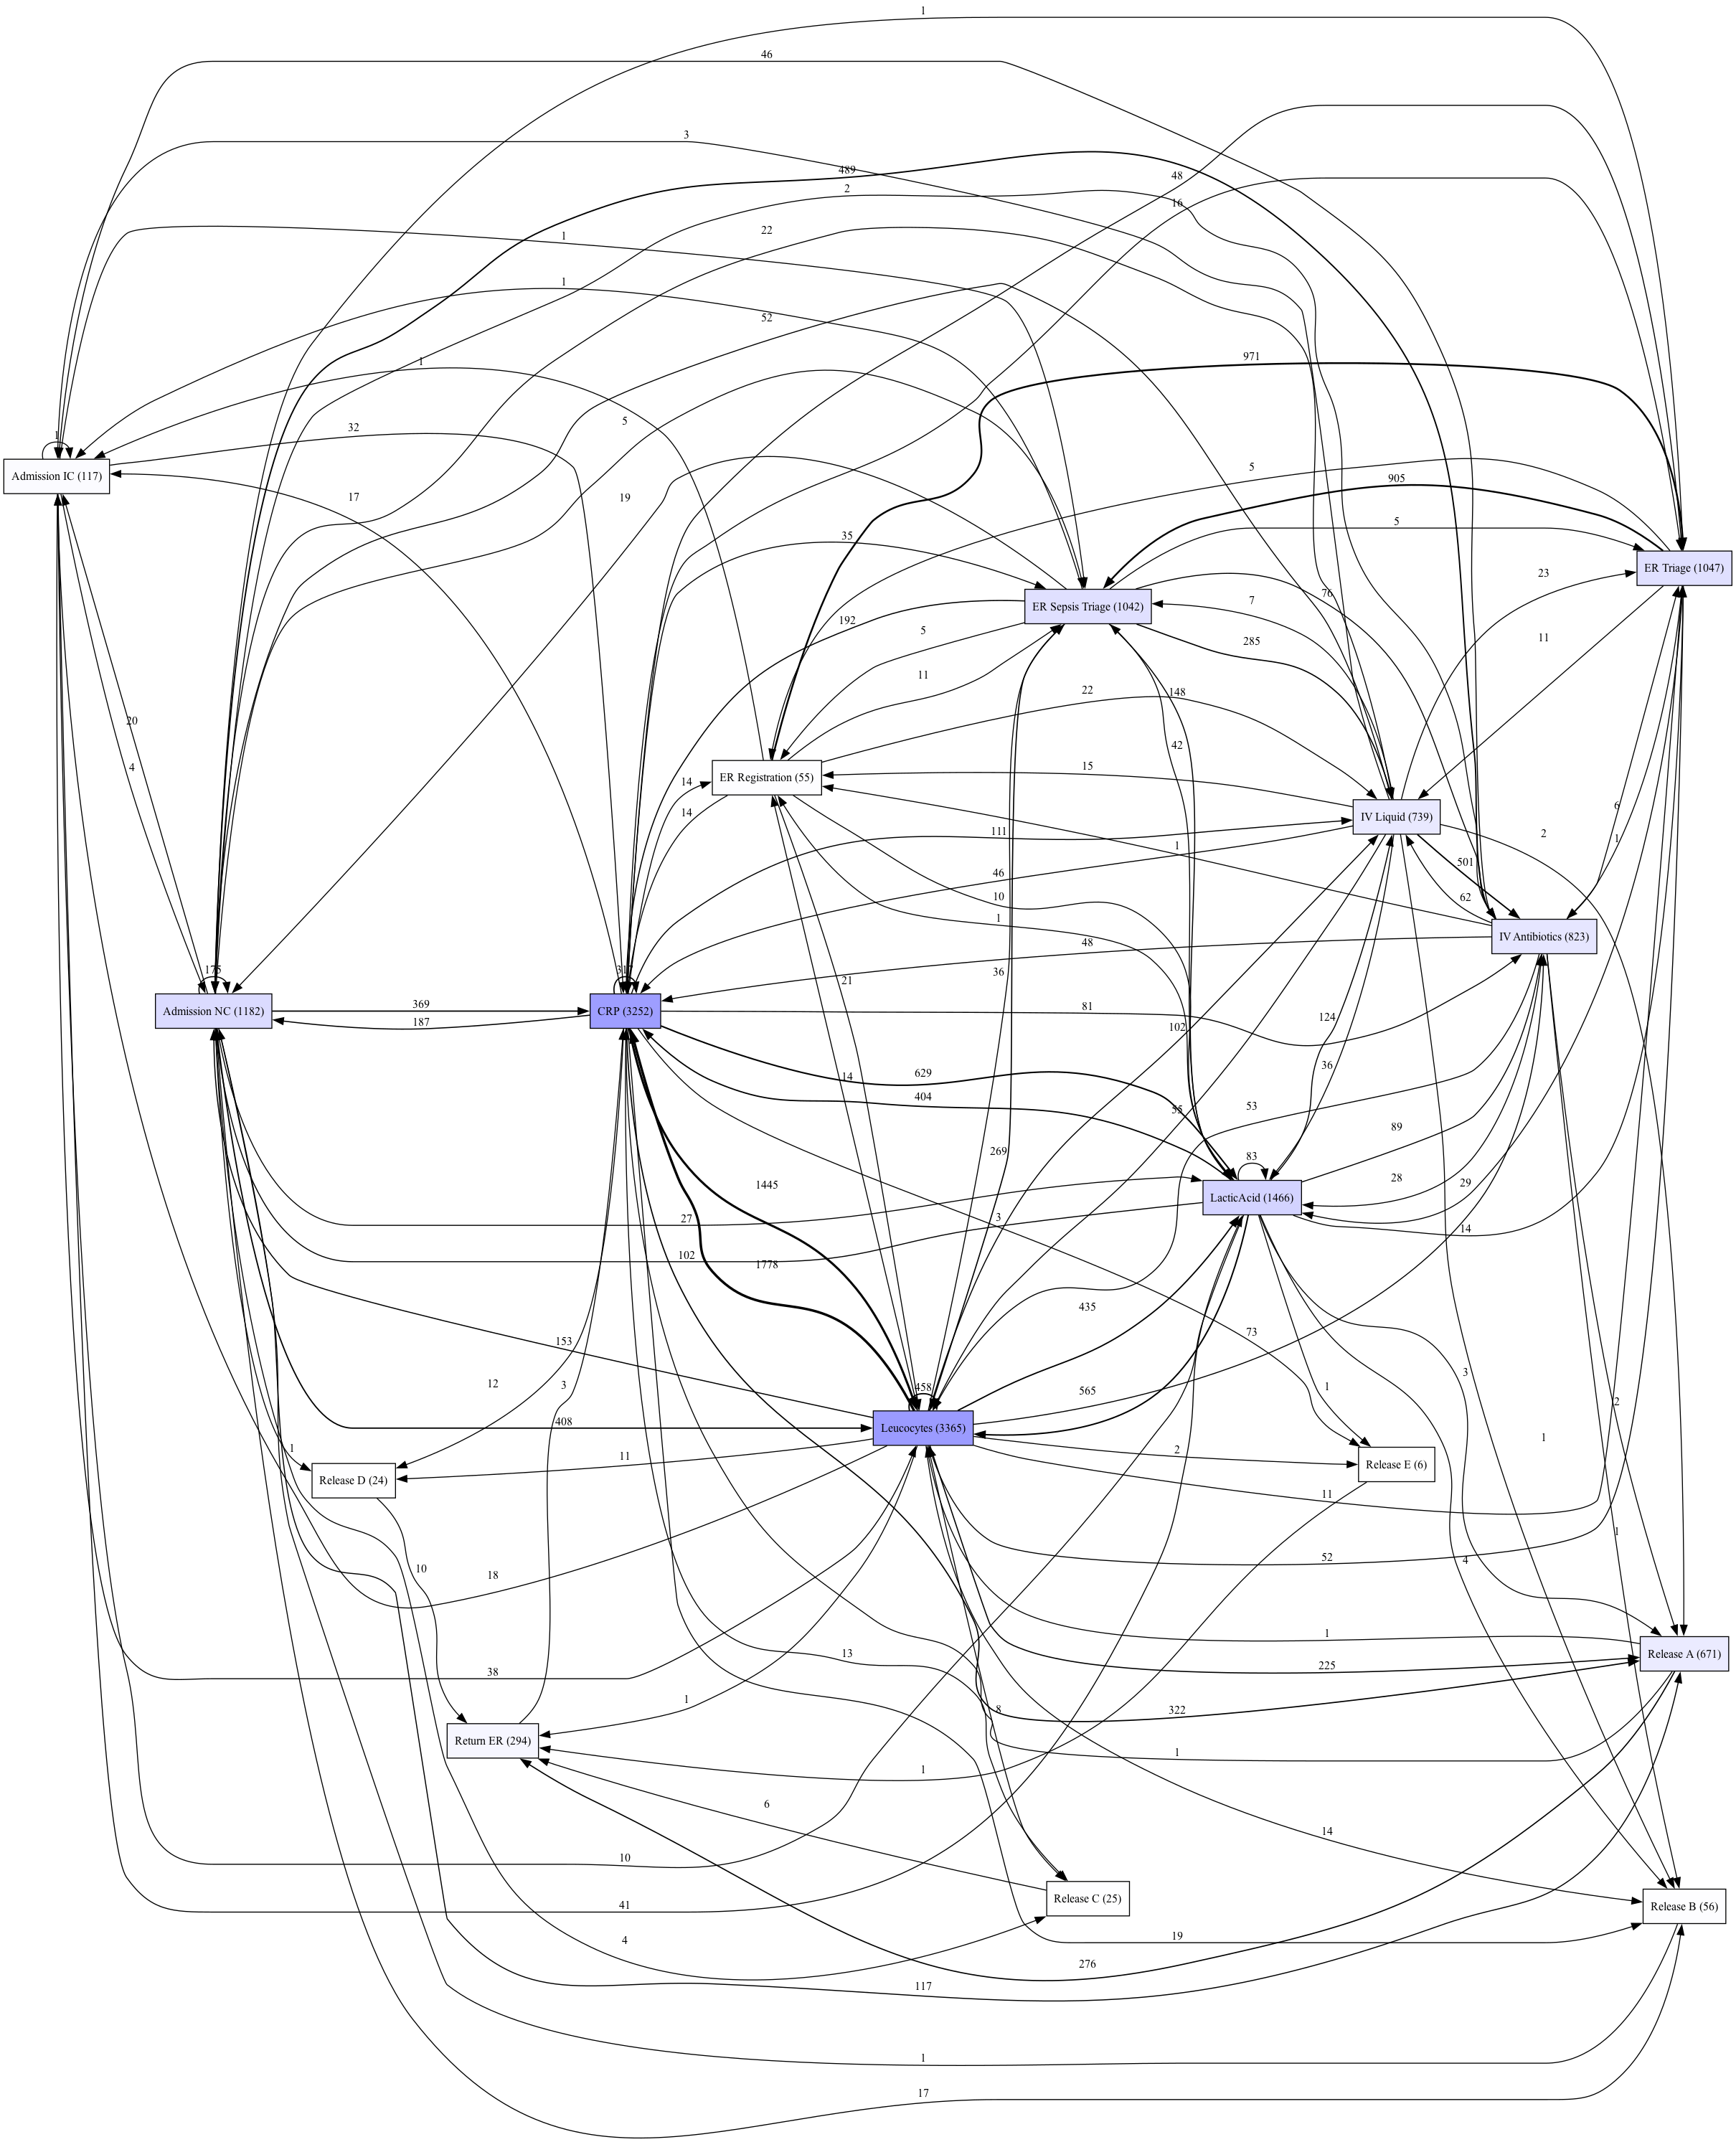

In [30]:
# Visualização do DFG (pode requerer graphviz instalado)
gviz = dfg_vis_factory.apply(dfg, variant=dfg_vis_factory.Variants.FREQUENCY)
dfg_vis_factory.view(gviz)

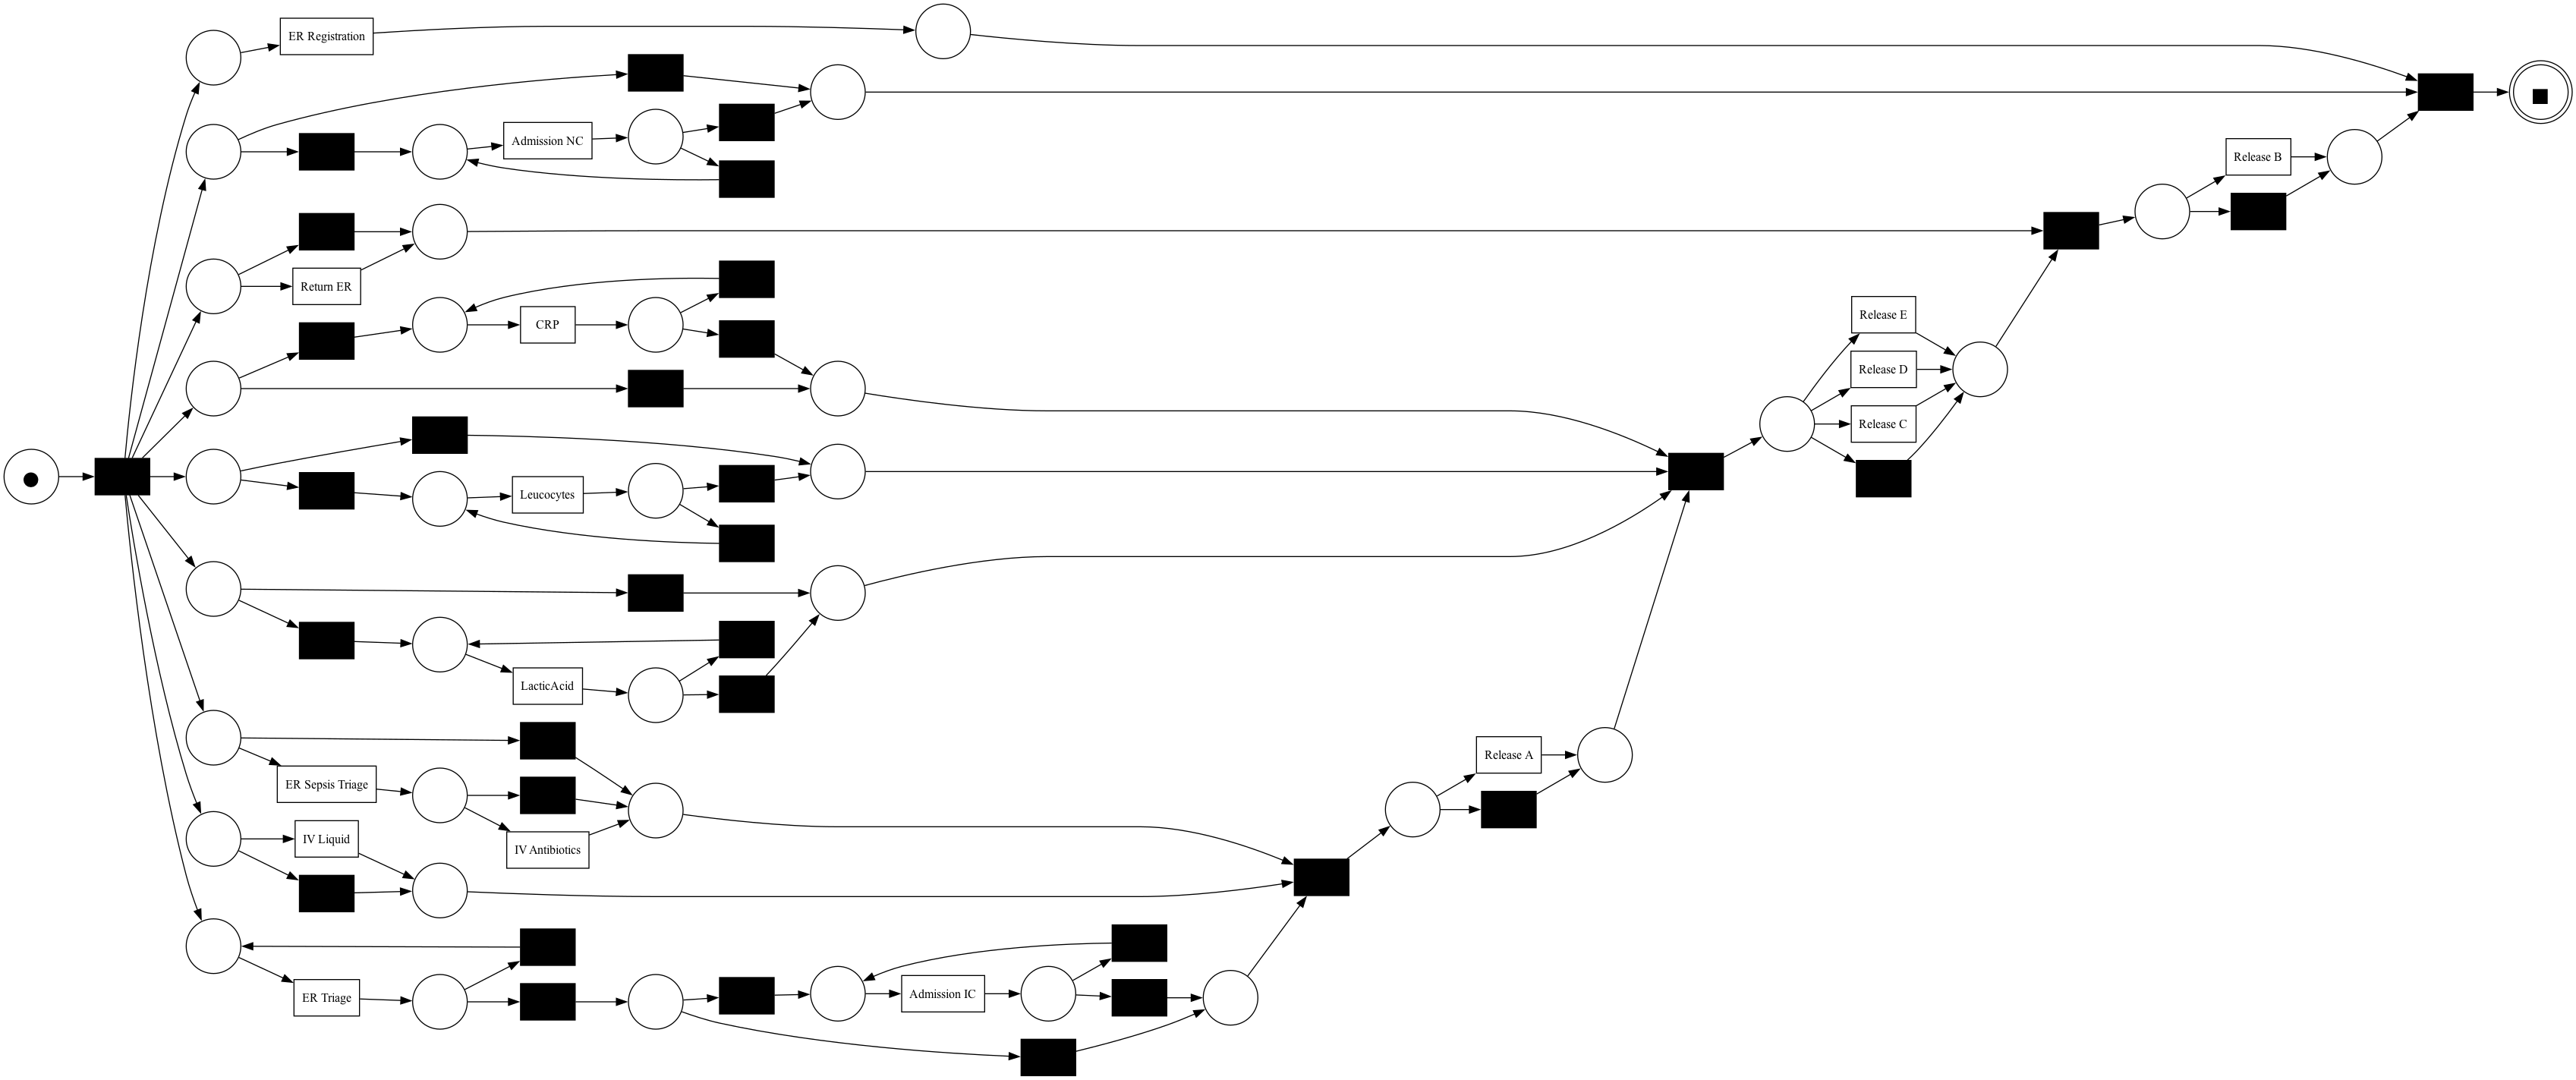

In [31]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# 1) Executa Inductive Miner → retorna ProcessTree
process_tree = inductive_miner.apply(log)

# 2) Converter ProcessTree → (net, im, fm)
net, im, fm = pt_converter.apply(process_tree)

# 3) Visualizar Petri Net (API moderna)
gviz_pn = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz_pn)

In [32]:
# Análise de desempenho: tempo de throughput por caso
throughput = df_events.groupby("case_id")["timestamp"].agg(["min", "max"])
throughput["throughput_hours"] = (
    throughput["max"] - throughput["min"]
).dt.total_seconds() / 3600
throughput.describe(percentiles=[0.5, 0.9, 0.95])

,throughput_hours
count,1050.0000
mean,683.2642
std,1452.8968
min,0.0339
50%,128.2413
90%,2225.6170
95%,3931.0085
max,10135.7747


## Rodar pipeline de Predictive RCA com o log Sepsis Cases

Gera um CSV temporário a partir do log baixado do PM4Py e executa o pipeline
com LightGBM


[2025-11-27 09:41:53,767] [PipelineBuilder] [INFO] Carregando log de eventos...
[2025-11-27 09:41:53,791] [PipelineBuilder] [INFO] Construindo features em nível de caso...
[2025-11-27 09:41:53,829] [PipelineBuilder] [INFO] Realizando split estratificado...
[2025-11-27 09:41:53,832] [PipelineBuilder] [INFO] Construindo preprocessor...
[2025-11-27 09:41:53,832] [PipelineBuilder] [INFO] Transformando dados...
[2025-11-27 09:41:53,839] [PipelineBuilder] [INFO] Treinando modelo final: LightGBMModel...


[LightGBM] [Info] Number of positive: 314, number of negative: 316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 303
[LightGBM] [Info] Number of data points in the train set: 630, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498413 -> initscore=-0.006349
[LightGBM] [Info] Start training from score -0.006349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[2025-11-27 09:41:54,049] [PipelineBuilder] [INFO] Avaliando em validação...
/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[2025-11-27 09:41:54,054] [PipelineBuilder] [INFO] Avaliando em teste...
/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[2025-11-27 09:41:54,058] [PipelineBuilder] [INFO] Plotando feature importance...


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
AUC-ROC: 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00       105

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210


Confusion matrix:
 [[105   0]
 [  0 105]]
AUC-ROC: 0.9999092970521541

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       105
           1       0.99      1.00      1.00       105

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.0

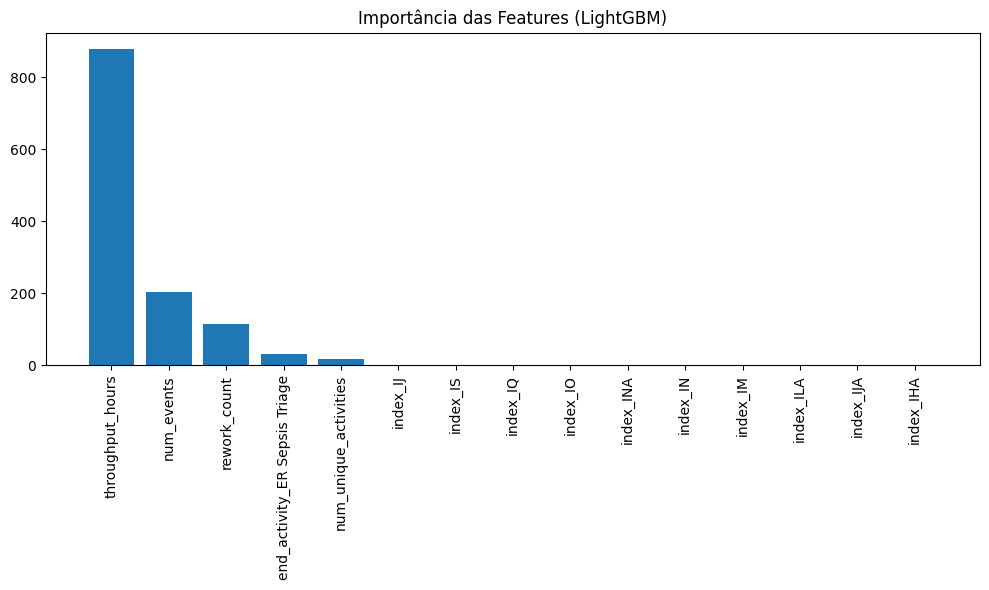

[2025-11-27 09:41:54,100] [PipelineBuilder] [INFO] Computando SHAP values...
/Users/pedroeckel/.local/share/virtualenvs/predictive-rca-9dRCaVbd/lib/python3.13/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
[2025-11-27 09:41:54,112] [PipelineBuilder] [INFO] Plotando SHAP summary...


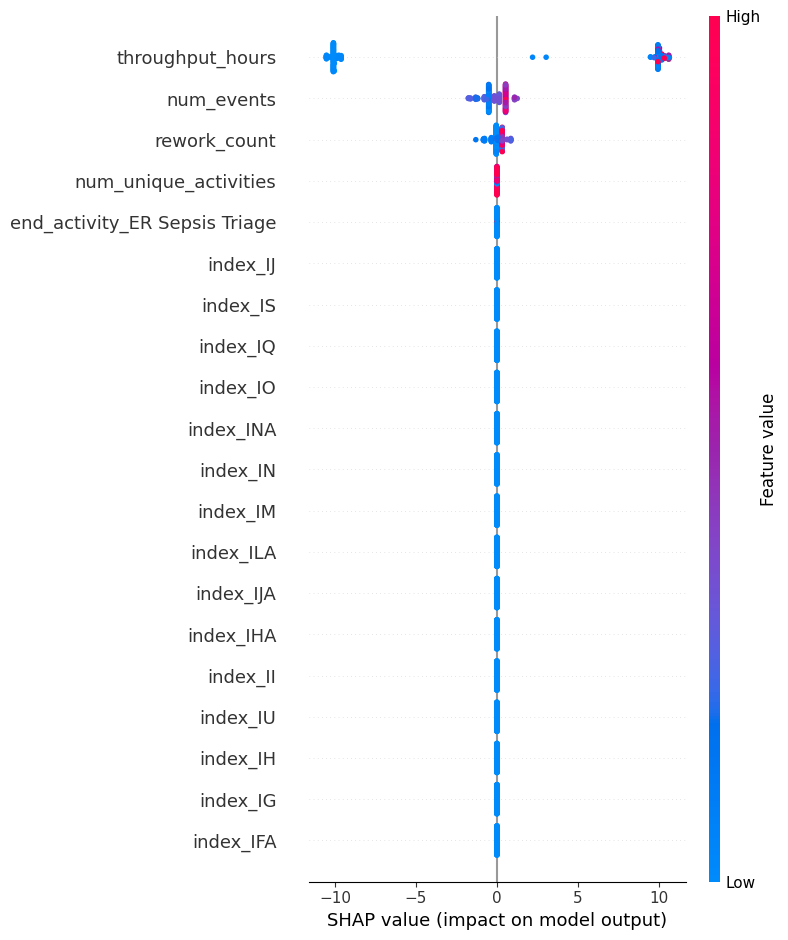

<Figure size 800x500 with 0 Axes>

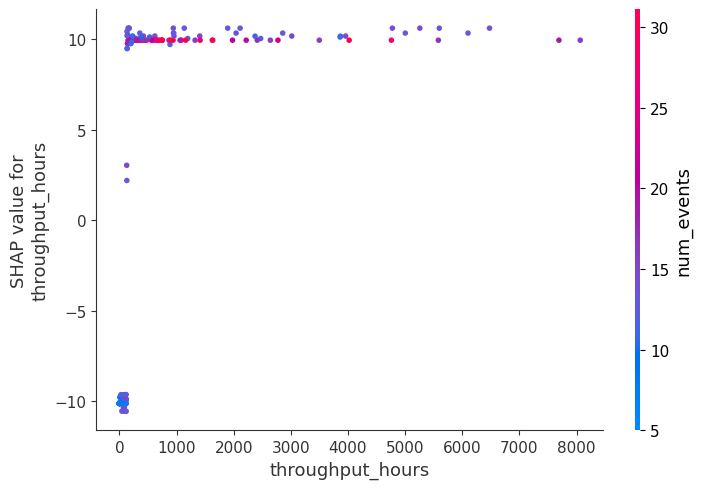

In [33]:
# Salvar o log em CSV temporário e executar o pipeline
# Alvo: casos com throughput acima da mediana (metade superior)

from importlib import reload
import src.pipeline.pipeline_builder as pipeline_builder

# Garante que a versão recarregada tenha a assinatura com target_builders
pipeline_builder = reload(pipeline_builder)
PipelineBuilder = pipeline_builder.PipelineBuilder


def build_above_median_target(
    features,
    throughput_col="throughput_hours",
    target_name="above_median_throughput",
):
    threshold = features[throughput_col].median()
    target = (features[throughput_col] > threshold).astype(int)
    target.name = target_name
    return target


interim_log_path = Path("data/interim/sepsis_cases_pm4py.csv")
interim_log_path.parent.mkdir(parents=True, exist_ok=True)

df_events.to_csv(interim_log_path, index=False)

pipeline = PipelineBuilder(
    model_class=LightGBMModel,
    optimize_hyperparams=False,
)

model, artifacts, splits = pipeline.run_from_event_log(
    str(interim_log_path),
    sla_hours=200,
    target_builders=[build_above_median_target],
    include_default_target=False,
    target_col="above_median_throughput",
)